In [1]:
import pandas as pd
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/storage/homefs/hb22g102/mambaforge/envs/env1

In [2]:
exp_s = Experiment(
    "ERA5", "s", "6H", (1940, 2023), [5, 6, 7, 8, 9], -60, 70, 25, 85, 250, None, None, None
)
da_s = exp_s.da
exp_s_low = Experiment(
    "ERA5", "s", "6H", (1940, 2023), [5, 6, 7, 8, 9], -60, 70, 25, 85, 700, None, None, None
)

In [3]:
(
    all_jets,
    where_are_jets,
    all_jets_one_array,
    all_jets_over_time,
    flags,
) = exp_s.track_jets()
flags = xr.DataArray(flags, coords=dict(time=da_s.time.values, jet=np.arange(flags.shape[1])))
props_as_ds_uncat = exp_s.props_as_ds(categorize=False)
props_as_ds_uncat = better_is_polar(all_jets, props_as_ds_uncat, exp_s_low.path)
props_as_ds = categorize_ds_jets(props_as_ds_uncat)
props_as_ds['exists'] = (~props_as_ds['mean_lon'].isnull()).astype(np.float32)
ds_pvs, ds_pvs_anoms = open_pvs(da_s)
da_jet_pos = jet_position_as_da(da_s, props_as_ds, props_as_ds_uncat, all_jets,exp_s.path)
events = gpd.read_parquet('/storage/scratch/users/hb22g102/ERA5/RWB_index/era5_pv_streamers_350K_1959-2022.parquet')
da_anti = ds_pvs['anti']
events_mask = da_anti.any(['lon', 'lat']).values
events_indices = np.where(events_mask)[0]
wind_to_pvs_mask = exp_s.da.time.isin(da_anti.time).values
wind_to_pvs_indices = np.where(wind_to_pvs_mask)[0]

100%|██████████| 51408/51408 [00:26<00:00, 1911.77it/s]


In [21]:
COMPUTE_KWARGS = {
    'n_workers': 12,
    'memory_limit': '4GiB',
}
da_s_ = da_s[wind_to_pvs_mask].assign_coords(hourofyear=compute_hourofyear(da_s))
coord = da_s_.hourofyear
da_s_ = flox.xarray.rechunk_for_cohorts(
    da_s_,
    dim="time",
    labels=coord,
    force_new_chunk_at=np.linspace(coord.min() // 12, coord.max() // 12, N_WORKERS * 32 + 2, dtype=int)[1:-1] * 12,
    ignore_old_chunks=True,
)
clim = flox.xarray.xarray_reduce(
    da_s_,
    coord,
    func="mean",
    method="cohorts",
).compute(**COMPUTE_KWARGS)

In [53]:
def mask_pvs(da: xr.DataArray, events: pd.DataFrame, da_anti: xr.DataArray, clim: xr.DataArray=None, n_offset: int = 24, q: float = 0.9) -> xr.DataArray:
    da_masked = None
    for offset in trange(n_offset):
        cond1 = (events_indices + offset) < len(da.time)
        cond2 = da.time.dt.year[events_indices + offset].values == da.time.dt.year[events_indices].values
        cond = cond1 & cond2
        indices = events_indices[cond] + offset
        if da_masked is None:
            event_flags = da_anti[indices].max(['lon', 'lat']).values
            events = events.iloc[event_flags]
            events_com_x = np.stack(events['com'].values)[:, 0]
            events_com_y = np.stack(events['com'].values)[:, 1]
            masks = {
                'west': events_com_x < np.quantile(events_com_x, 1 - q),
                'east': events_com_x > np.quantile(events_com_x, q),
                'south': events_com_y < np.quantile(events_com_y, 1 - q),
                'north': events_com_y > np.quantile(events_com_y, q),
                'intense': (events['intensity'] > np.quantile(events['intensity'], q)).values,
                'large': (events['event_area'] > np.quantile(events['event_area'], q)).values,
            }
            base_coords = {dim: getattr(da, dim).values for dim in da.dims if dim != 'time'}
            coords = {
                         'event_type': ['all'] + list(masks),
                         'time_around_event': np.arange(n_offset)
                     } | base_coords
            da_masked = xr.DataArray(data=np.zeros([len(c) for c in coords.values()]) + np.nan, coords=coords)
        if clim is not None:
            clim_coord = clim.dims[0]
            to_assign = da[indices].groupby(clim_coord) - clim
        else:
            to_assign = da[indices]
        da_masked.loc['all', offset, ...] = to_assign.mean(dim='time').values
        for event_type, mask in masks.items():
            to_assign = da[indices[mask]]
            to_assign = to_assign if clim is None else to_assign.groupby(clim_coord) - clim
            da_masked.loc[event_type, offset, ...] = to_assign.mean(dim='time').values
    return da_masked

In [56]:
da_masked_pvs = mask_pvs(da_s_, events, da_anti, clim)

100%|██████████| 24/24 [00:21<00:00,  1.10it/s]


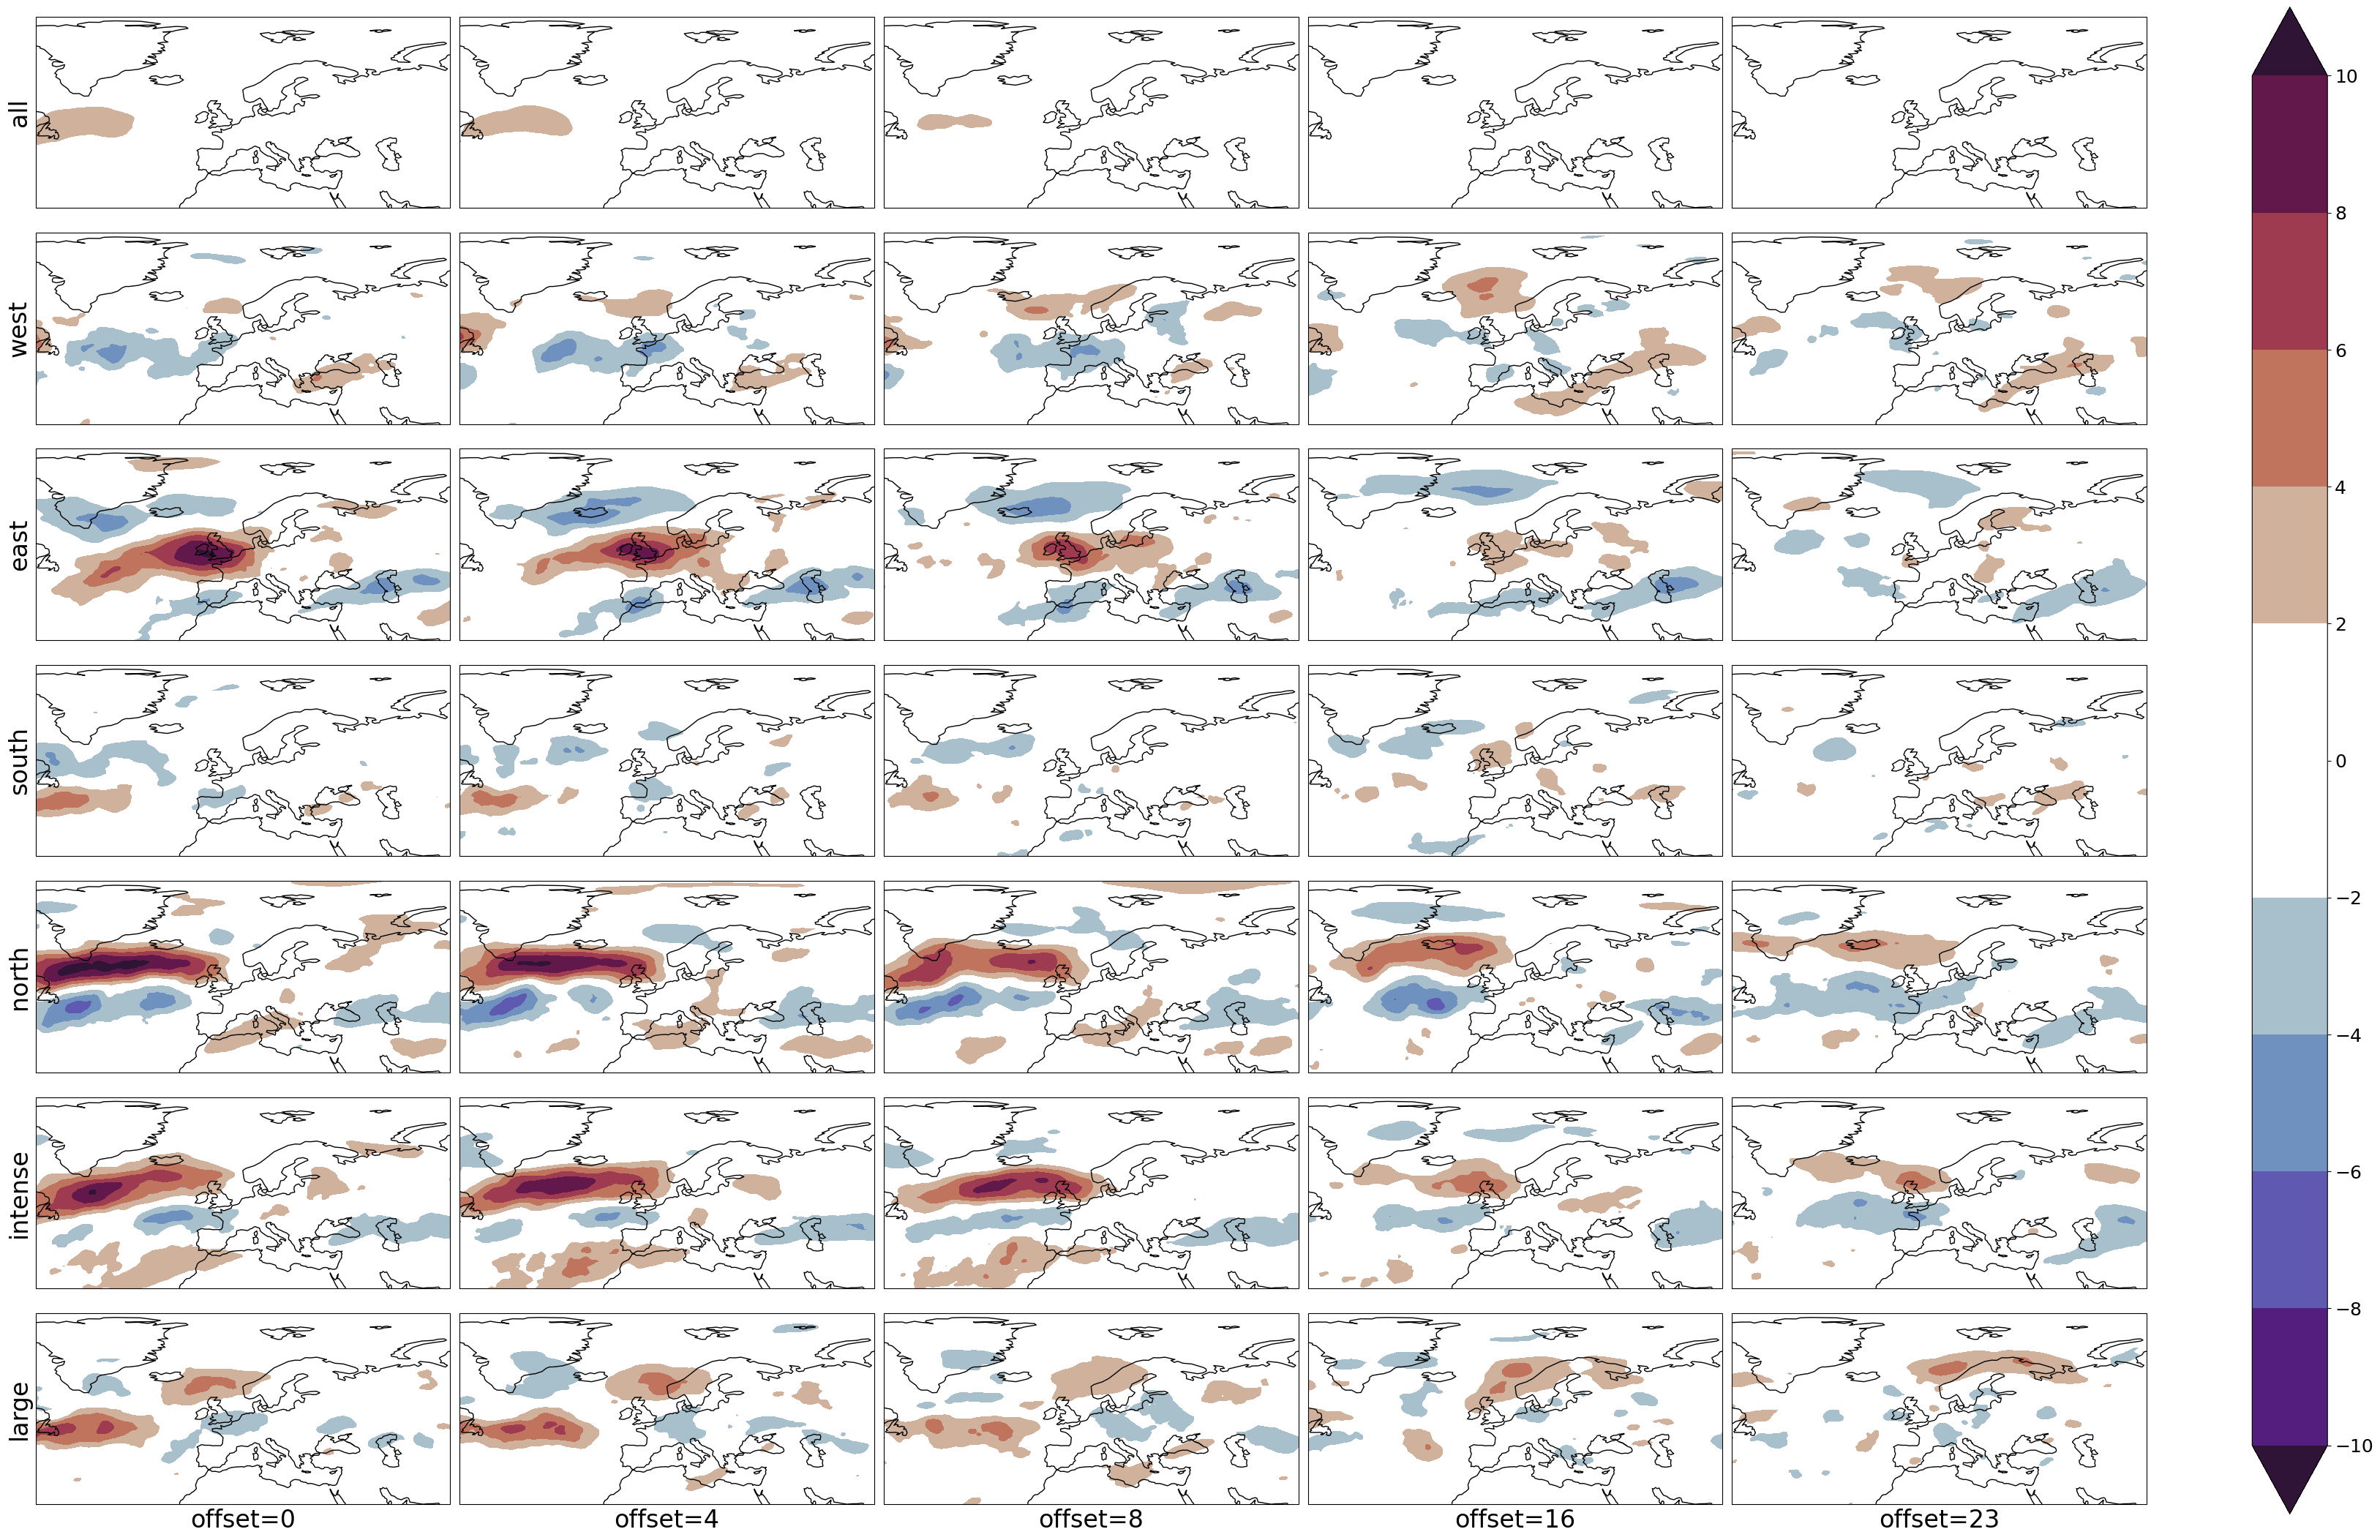

In [57]:
offsets = [0, 4, 8, 16, 23]
clu = Clusterplot(len(da_masked_pvs.event_type), len(offsets), region=get_region(da_masked_pvs))
_ = clu.add_contourf([da_masked_pvs.loc[event_type, offset] for event_type in da_masked_pvs.event_type for offset in offsets], transparify=True, q=0.99)
for i, event_type in enumerate(da_masked_pvs.event_type.values):
    k = len(offsets) * i
    clu.axes[k].set_yticks([])
    clu.axes[k].set_ylabel(event_type, fontsize=24)
for i, offset in enumerate(offsets):
    k = len(offsets) * (len(da_masked_pvs.event_type) - 1) + i
    clu.axes[k].set_xticks([])
    clu.axes[k].set_xlabel(f"{offset=}", fontsize=24)

In [58]:
da_jp_masked = mask_pvs(da_jet_pos[wind_to_pvs_mask], events, da_anti)

100%|██████████| 24/24 [00:14<00:00,  1.64it/s]


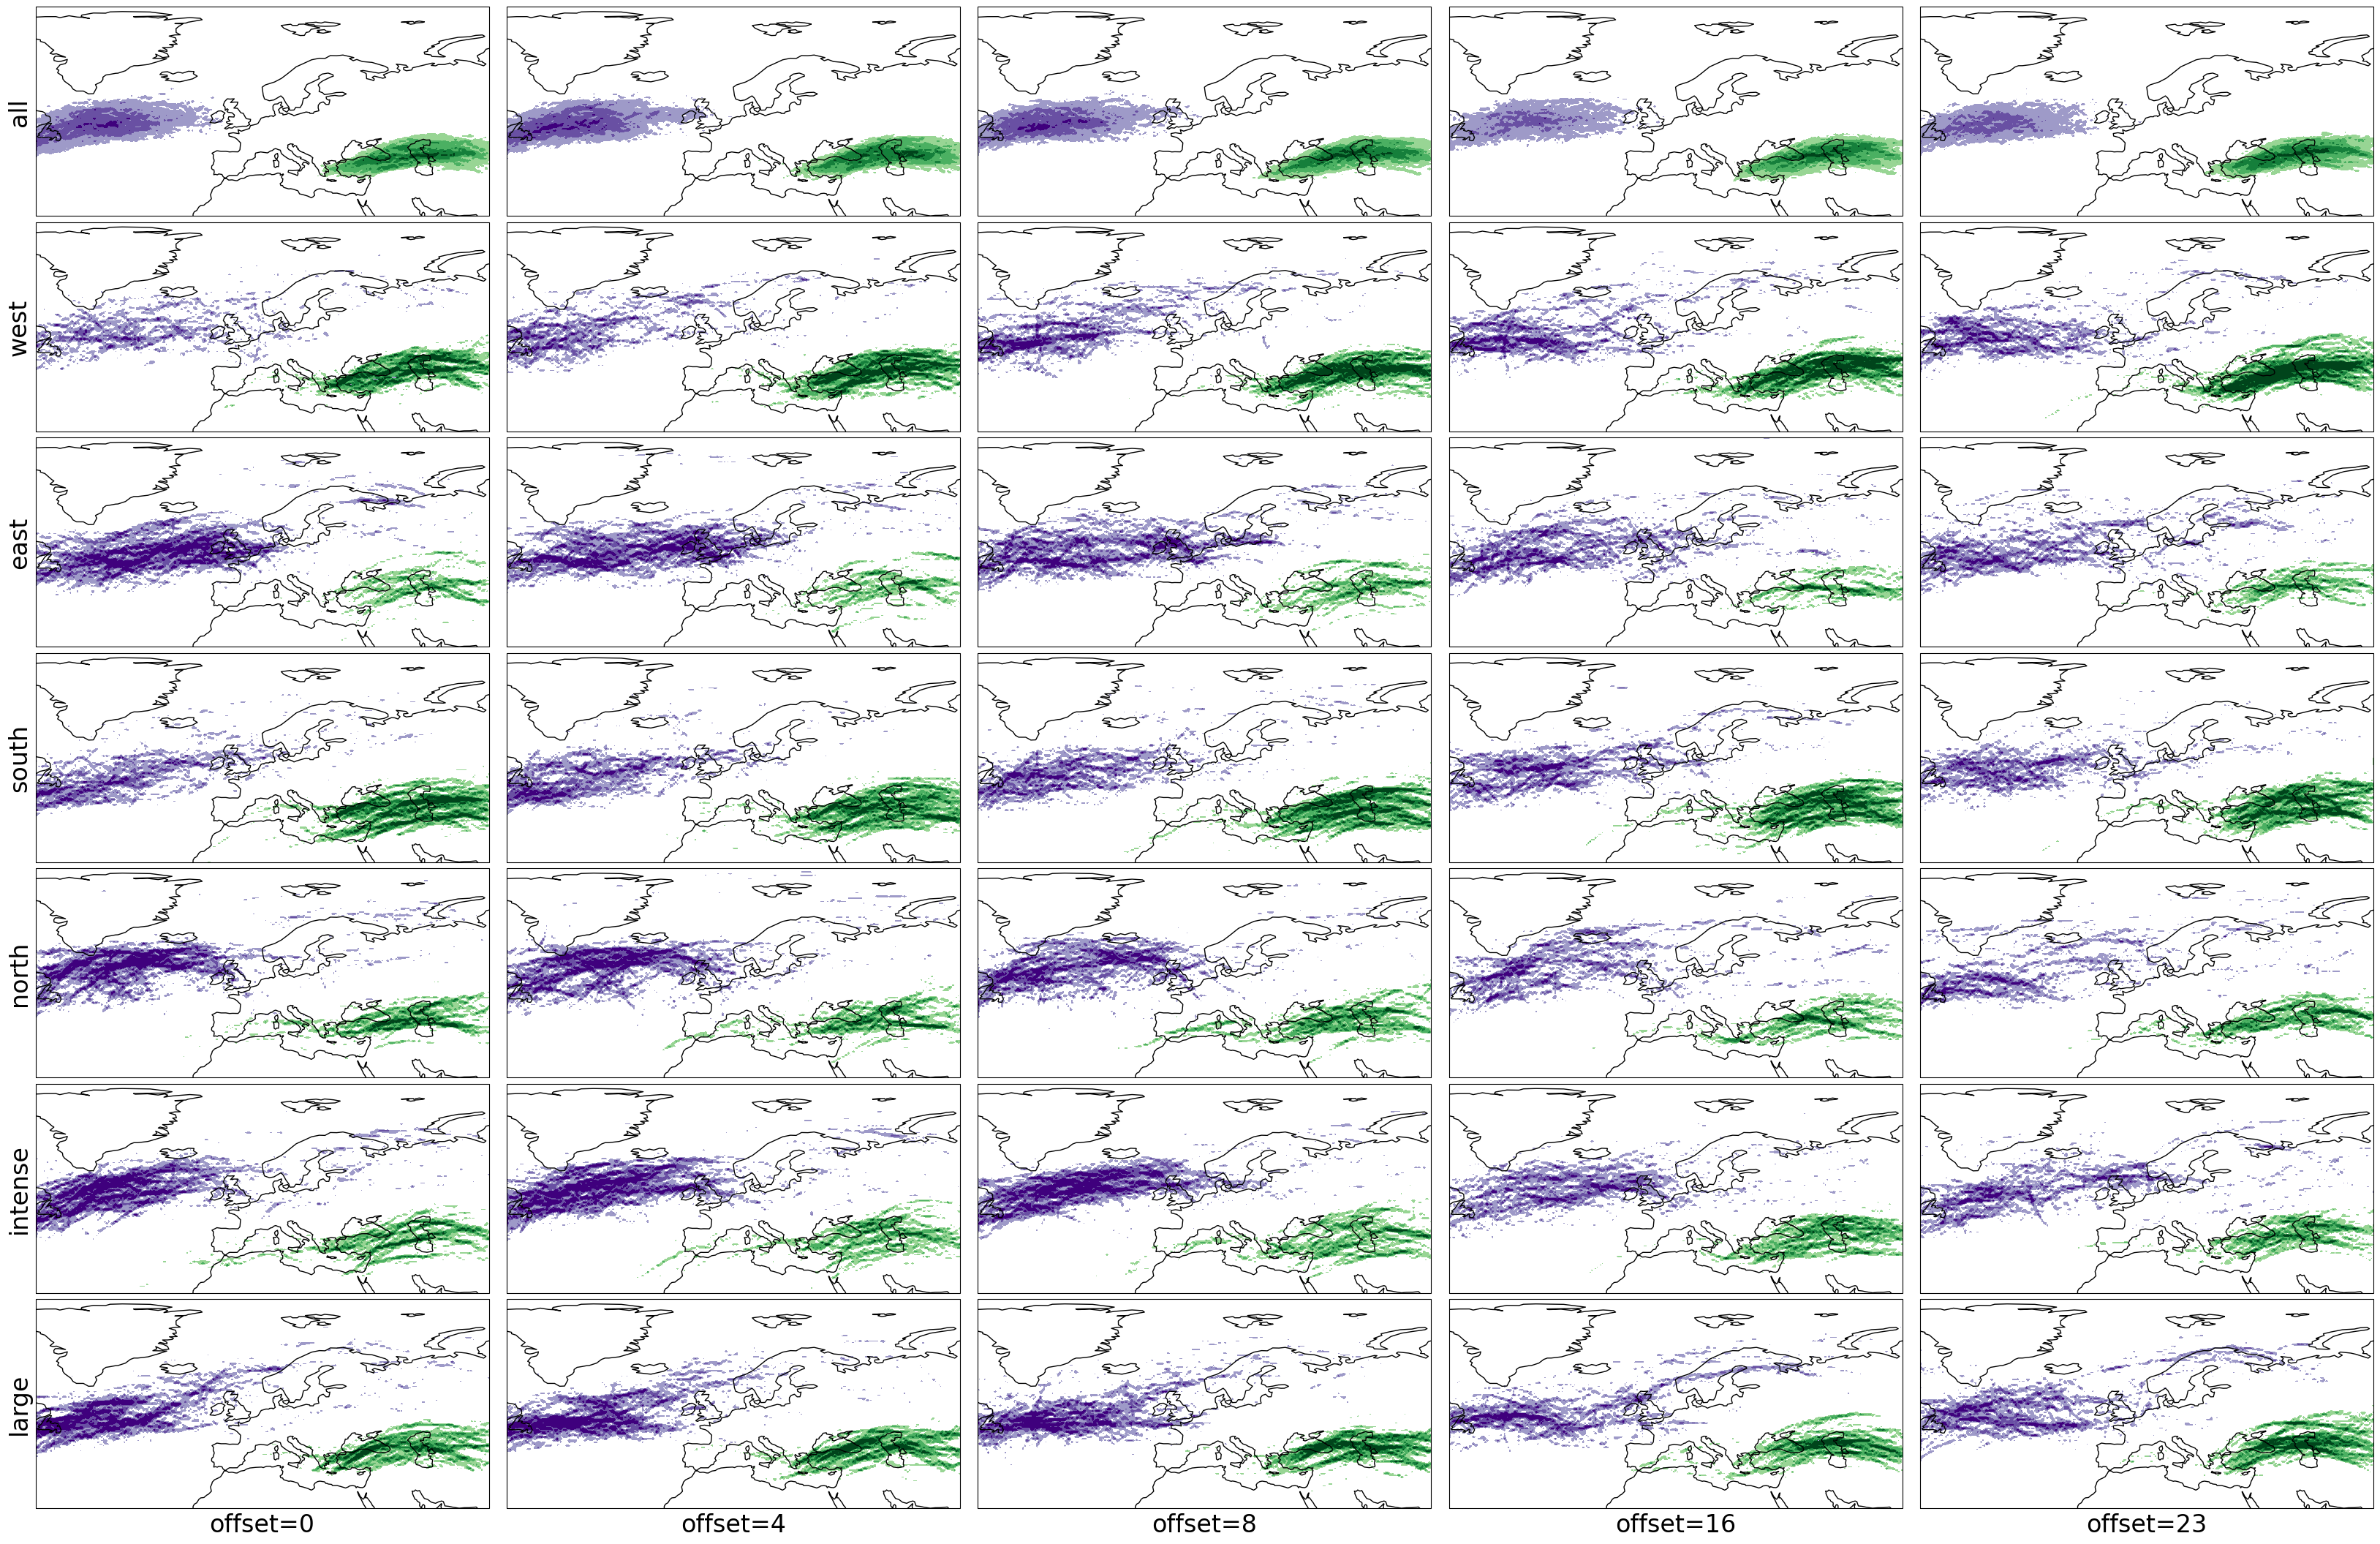

In [59]:
offsets = [0, 4, 8, 16, 23]
clu = Clusterplot(len(da_jp_masked.event_type), len(offsets), region=get_region(da_jp_masked))
_ = clu.add_contourf([da_jp_masked.loc[event_type, offset, 'subtropical'] for event_type in da_jp_masked.event_type for offset in offsets], transparify=2, q=0.99, cmap='Greens', draw_cbar=False)
_ = clu.add_contourf([da_jp_masked.loc[event_type, offset, 'polar'] for event_type in da_jp_masked.event_type for offset in offsets], transparify=2, q=0.99, cmap='Purples', draw_cbar=False)
for i, event_type in enumerate(da_jp_masked.event_type.values):
    k = len(offsets) * i
    clu.axes[k].set_yticks([])
    clu.axes[k].set_ylabel(event_type, fontsize=24)
for i, offset in enumerate(offsets):
    k = len(offsets) * (len(da_jp_masked.event_type) - 1) + i
    clu.axes[k].set_xticks([])
    clu.axes[k].set_xlabel(f"{offset=}", fontsize=24)

In [7]:
COMPUTE_KWARGS = {
    'n_workers': 12,
    'memory_limit': '4GiB',
}
ds = props_as_ds.loc[dict(time=wind_to_pvs_mask)]
ds = ds.assign_coords(hourofyear=compute_hourofyear(ds))
coord = ds.hourofyear
ds = flox.xarray.rechunk_for_cohorts(
    ds,
    dim="time",
    labels=coord,
    force_new_chunk_at=np.linspace(coord.min() // 12, coord.max() // 12, N_WORKERS * 32 + 2, dtype=int)[1:-1] * 12,
    ignore_old_chunks=True,
)
clim_props = flox.xarray.xarray_reduce(
    ds,
    coord,
    func="mean",
    method="cohorts",
).compute(**COMPUTE_KWARGS)

In [63]:
props_masked_pvs = None
offsets = np.arange(-12, 12)
for offset in tqdm(offsets):
    cond1 = ((events_indices + offset) < len(da_s_.time)) & ((events_indices + offset) >= 0)
    cond2 = da_s_.time.dt.year[events_indices + offset].values == da_s_.time.dt.year[events_indices].values
    cond = cond1 & cond2
    indices = events_indices[cond] + offset
    if props_masked_pvs is None:
        props_masked_pvs = props_as_ds.loc[dict(time=props_as_ds.time[0].values)].reset_coords('time', drop=True)
        for varname in props_masked_pvs.data_vars:
            props_masked_pvs[varname][:] = np.nan
        coords = {
            'event': np.arange(len(indices)),
            'time_around_event': offsets
        }
        props_masked_pvs = props_masked_pvs.expand_dims(coords).copy(deep=True)
        event_flags = da_anti[indices].max(['lon', 'lat']).values
        events = gpd.read_parquet('/storage/scratch/users/hb22g102/ERA5/RWB_index/era5_pv_streamers_350K_1959-2022.parquet')
        events = events.iloc[event_flags]
        props_masked_pvs = props_masked_pvs.assign_coords(event_flag=('event', event_flags))
        props_masked_pvs = props_masked_pvs.assign_coords(com_x=('event', np.stack(events['com'].values)[:, 0]))
        props_masked_pvs = props_masked_pvs.assign_coords(com_y=('event', np.stack(events['com'].values)[:, 1]))
        props_masked_pvs = props_masked_pvs.assign_coords(mean_var=('event', events['mean_var']))
        props_masked_pvs = props_masked_pvs.assign_coords(event_area=('event', events['event_area']))
        props_masked_pvs = props_masked_pvs.assign_coords(intensity=('event', events['intensity']))
    subds = ds.loc[dict(time=ds.time[indices].values)]
    subds = subds.groupby(subds.hourofyear) - clim_props
    subds = subds.assign_coords(time=np.where(cond)[0]).rename(time='event')
    props_masked_pvs.loc[dict(event=np.where(cond)[0], time_around_event=offset)] = subds

100%|██████████| 24/24 [00:03<00:00,  6.25it/s]


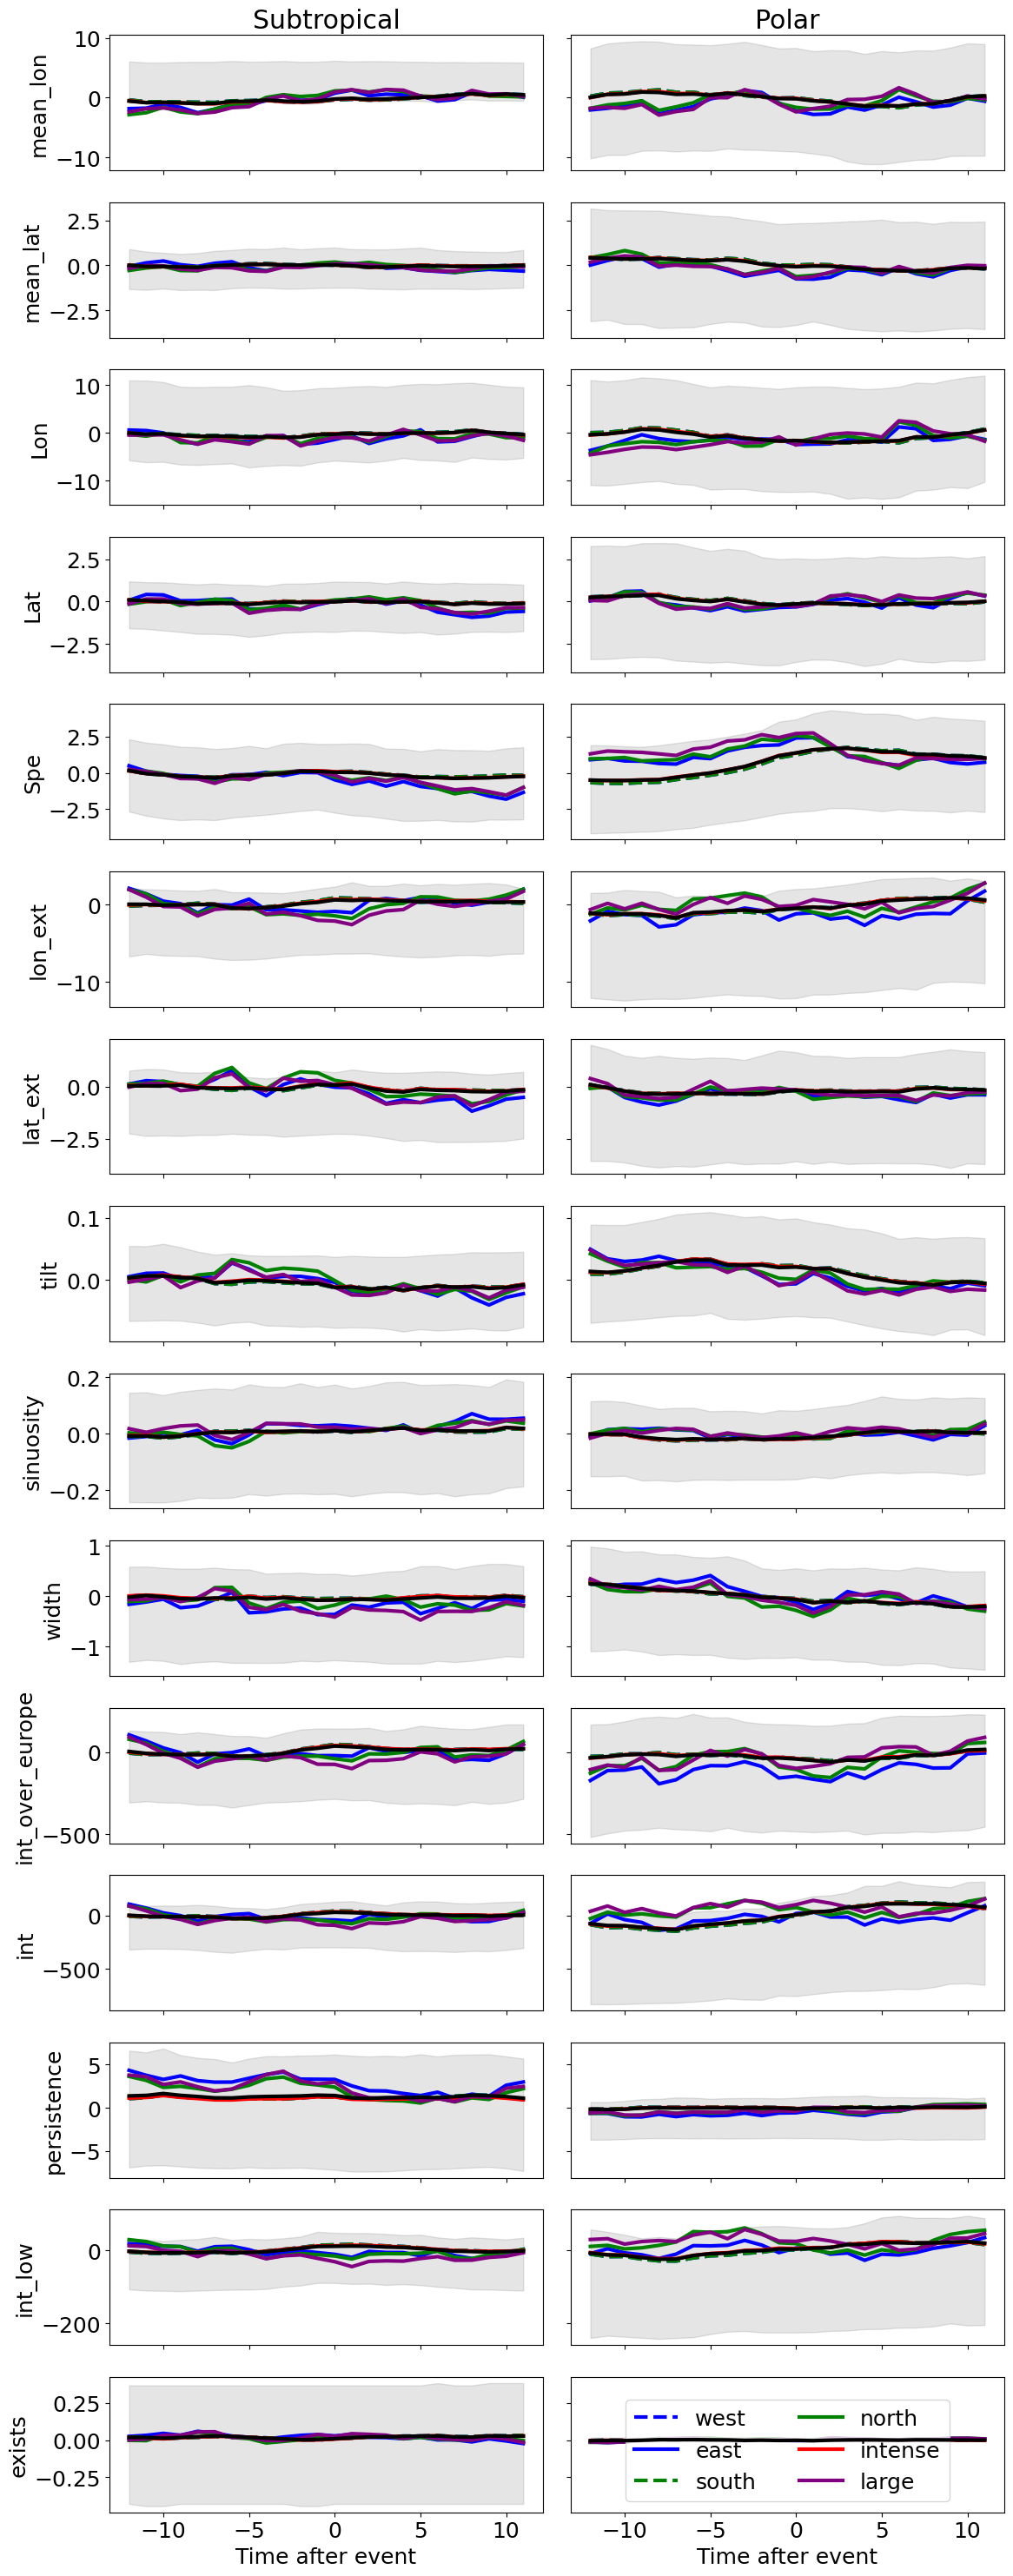

In [66]:
fig, axes = plt.subplots(len(props_masked_pvs.data_vars), 2, figsize=(12, 30), sharex='all', sharey='row', tight_layout=True)
x = props_masked_pvs.time_around_event.values
q = 0.9
colors = ['blue', 'blue', 'green', 'green', 'red', 'purple']
linestyles = ['dashed', 'solid', 'dashed', 'solid', 'solid', 'solid']
for axs, varname in zip(axes, props_masked_pvs.data_vars):
    for ax, jet in zip(axs, props_masked_pvs.jet.values):
        da = props_masked_pvs[varname].sel(jet=jet)
        to_plot = da.mean(dim='event')
        ax.plot(x, to_plot.values, lw=3, color='black', zorder=1000)
        q1, q2 = da.quantile([0.33, 0.66], dim='event').values
        ax.fill_between(x, q1, q2, alpha=0.1, color='black')
        if jet == 'subtropical':
            ax.set_ylabel(varname)
        masks = {
            'west': da.com_x <= da.com_x.quantile(q=1 - q),
            'east': da.com_x >= da.com_x.quantile(q=q),
            'south': da.com_y <= da.com_y.quantile(q=1 - q),
            'north': da.com_y >= da.com_y.quantile(q=q),
            'intense': da.intensity >= da.intensity.quantile(q=q),
            'large': da.event_area >= da.event_area.quantile(q=q),
        }
        for (mask_name, mask), color, linestyle in zip(masks.items(), colors, linestyles):
            y = da.sel(event=mask).mean(dim='event').values
            ax.plot(x, y, label=mask_name, lw=3, color=color, linestyle=linestyle)
axes[0, 0].set_title('Subtropical')
axes[0, 1].set_title('Polar')
axes[-1, 0].set_xlabel('Time after event')
axes[-1, 1].set_xlabel('Time after event')
axes[-1, -1].legend(ncol=2)